# Topic Subscription AB Test Analysis [DRAFT]

**Megan Neisler, Senior Data Scientist, Wikimedia Foundation**

** 22 July 2022**

[TASK](https://phabricator.wikimedia.org/T280897) | [CODEBASE](https://github.com/wikimedia-research/Topic-notifications-analysis-2022)

# Table of Contents

1. [Introduction](#Introduction)
2. [Methodology](#Methodology)

FIXME: UPDATE

# Introduction

The Wikimedia Foundation's [Editing team](https://www.mediawiki.org/wiki/Editing_team#:~:text=The%20Editing%20team%20is%20the,tools%20like%20TemplateData%20and%20Citoid.) is working to improve how contributors communicate on Wikipedia using talk pages through a series of incremental improvements that will be released over time.

As part of this effort, the Editing team is working to to improve the notifications editors receive for the wikitext talk page conversations they are interested in. This work is intended to increase the likelihood Junior and Senior Contributors receive timely and relevant responses to the comment they post and conversations they start on wikitext talk pages, regardless of the tool used to publish these comments and conversations. 

The team ran an AB test of the notifications feature from 2 June 2022 through 15 July 2022 to assess the efficacy of this new feature. The test included all logged-in users that edited at one the 20 participating Wikipedias  during the duration of the AB test (see full list of [participating Wikipedias in task description](https://phabricator.wikimedia.org/T304027) and conditions outlined in the methodology section below). During this test, 50% of users included in the test had the Manual and Automatic topic subsctiption automatically enabled, and 50% did not.

You can find more information about features of this tool and project updates on the [project page](https://www.mediawiki.org/w/index.php?title=Talk_pages_project/Notifications&useskin=vector-2022).

# Methodology

Upon conclusion of the test on 15 July 2022, we recorded a total of 54,138 comments posted on a talk page by 9,997 distinct logged-in contributors across all experience levels.  A total of 4,781 (48%) of these contributors were identified as Junior Contributors. Data was collected in [EditAttemptStep](https://gerrit.wikimedia.org/r/plugins/gitiles/schemas/event/secondary/+/refs/heads/master/jsonschema/analytics/legacy/editattemptstep/) and [talk_page_edit](https://schema.wikimedia.org/repositories//secondary/jsonschema/analytics/mediawiki/talk_page_edit/current.yaml) .

All of the participating wikis have access the same set of other tools: new topic and reply tool and editing interfaces.
FIXME: FILL IN BASED ON DETAILS IN
https://phabricator.wikimedia.org/T304030

In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [141]:
shhh <- function(expr) suppressPackageStartupMessages(suppressWarnings(suppressMessages(expr)))
shhh({
    library(tidyverse)
    library(lubridate)
   # Modeling 
    library(brms)
    library(lme4)
    library(tidybayes)
    set.seed(5)
    # Tables:
    library(gt)
    library(gtsummary)
})

In [15]:
options(repr.plot.width = 15, repr.plot.height = 10)

In [460]:
query <- "SELECT
  date_format(eas.dt, 'yyyy-MM-dd') as attempt_dt,
  date_format(tpe.dt, 'yyyy-MM-dd') as save_dt,
  event.editing_session_id as edit_attempt_id,
  wiki AS wiki,
  event.bucket AS experiment_group,
  event.editor_interface as interface,
  event.integration as integration,
  event.user_id as user_id,
  event.is_oversample AS is_oversample,
  IF(tpe.session_id IS NOT NULL, 'comment_posted', 'no_comment_posted') AS edit_save_status,
  tpe.component_type AS comment_type,
  tpe.topic_id AS topic_id,
  tpe.comment_id AS comment_id,
  tpe.comment_parent_id AS comment_parent_id,
  event.user_editcount AS experience_level
FROM event.editattemptstep eas
LEFT JOIN 
 event.mediawiki_talk_page_edit tpe
 ON  event.editing_session_id = tpe.session_id
 AND wiki = tpe.`database`
   AND tpe.Year = 2022
  AND ((tpe.month = 06 AND tpe.day >= 02) OR (tpe.month = 07 and tpe.day <= 15))
WHERE
-- AB test timline
  eas.Year = 2022
   AND ((eas.month = 06 AND eas.day >= 02) OR (eas.month = 07 and eas.day <= 15))
 -- remove bots
   AND useragent.is_bot = false
-- review all talk namespaces
   AND event.page_ns % 2 = 1
-- only test events
   AND event.bucket in ('test', 'control')
   AND event.platform = 'desktop'
   AND event.action = 'init'
-- review participating wikis list
   AND wiki IN ('amwiki', 'arzwiki', 'bnwiki', 'eswiki', 'fawiki', 'frwiki', 'hewiki',  'hiwiki',  'idwiki', 'itwiki',  'jawiki',  
 'kowiki', 'nlwiki', 'omwiki', 'plwiki', 'ptwiki',  'thwiki',
    'ukwiki', 'viwiki','zhwiki')
-- only logged in users
   AND event.user_id != 0 "

In [461]:
topic_events <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [462]:
# Data cleaning and reformating

# reformat user-id and adjust to include wiki to account for duplicate user id instances.
# Users do not have the smae user_id on different wikis
topic_events$user_id <-
  as.character(paste(topic_events$user_id, topic_events$wiki, sep ="-"))

# divide experiene level groups
topic_events <- topic_events %>%
    mutate(experience_group = cut(as.numeric(experience_level), 
                                         breaks = c(0, 100, 500, 
                                                    Inf), 
                                         labels = c('0-100 edits', '101-500 edits', 'over 500 edits'), include.lowest = TRUE))

#clarfiy wiki names
topic_events <- topic_events %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'amwiki' ~ "Amharic Wikipedia", 
      wiki == 'bnwiki' ~ "Bengali Wikipedia", 
      wiki == 'zhwiki' ~ "Chinese Wikipedia", 
      wiki == 'nlwiki' ~ 'Dutch Wikipedia', 
      wiki == 'arzwiki' ~ 'Egyptian Wikipedia', 
      wiki == 'frwiki' ~ 'French Wikipedia', 
      wiki == 'hewiki' ~ 'Hebrew Wikipedia', 
      wiki == 'hiwiki' ~ 'Hindi Wikipedia', 
      wiki == 'idwiki' ~ 'Indonesian Wikipedia', 
      wiki == 'itwiki' ~ 'Italian Wikipedia',  
      wiki == 'jawiki' ~ 'Japanese Wikipedia',    
      wiki == 'kowiki' ~ 'Korean Wikipedia', 
      wiki == 'omwiki' ~ 'Oromo Wikipedia', 
      wiki == 'fawiki' ~ 'Persian Wikipedia', 
      wiki == 'plwiki' ~ 'Polish Wikipedia',   
      wiki == 'ptwiki' ~ 'Portuguese Wikipedia', 
      wiki == 'eswiki' ~ 'Spanish Wikipedia', 
      wiki == 'thwiki' ~ 'Thai Wikipedia',   
      wiki == 'ukwiki' ~ 'Ukrainian Wikipedia', 
      wiki == 'viwiki' ~ 'Vietnamese Wikipedia'   
    )
  ) 


# Data exploration: Talk page edit attempts and comments by test group

We first explored the numbers of talk page edit attempts posted by users in each experiment group in the AB test to understand the scale and distribution of events across all participating wikis.

### Overall Talk Page Edit Attempts

In [463]:
talk_page_attempts_bygroup <- topic_events %>%
   #filter(is_oversample == 'false') %>% #All Discussion Tool events are oversampled - removing to check balance.
  group_by(experiment_group, edit_save_status) %>%
  summarise(users = n_distinct(user_id),
        attempts = n_distinct(edit_attempt_id), .groups = 'drop')

talk_page_attempts_bygroup

experiment_group,edit_save_status,users,attempts
<chr>,<chr>,<int>,<int>
control,comment_posted,4990,27258
control,no_comment_posted,6249,22821
test,comment_posted,5021,26880
test,no_comment_posted,6094,21004


### Talk Page Edit Attempts by Experience Group

In [431]:
talk_page_attempts_byjunior <- topic_events %>%
 #filter(edit_save_status == 'comment_posted')  %>%
  mutate(experience_group =
         case_when(
             experience_level < 100 ~ "under 100 edits",
             experience_level >=100 & experience_level <= 500 ~ "between 100 and 500 edits",
             experience_level > 500 ~ "over 500 edits"
             )) %>%
  group_by(experience_group, experiment_group, edit_save_status) %>%
  summarise(users = n_distinct(user_id),
        attempts = n_distinct(edit_attempt_id), .groups = 'drop')

talk_page_attempts_byjunior

experience_group,experiment_group,edit_save_status,users,attempts
<chr>,<chr>,<chr>,<int>,<int>
between 100 and 500 edits,control,comment_posted,556,2104
between 100 and 500 edits,test,comment_posted,606,2341
over 500 edits,control,comment_posted,2131,20320
over 500 edits,test,comment_posted,2116,19484
under 100 edits,control,comment_posted,2384,4834
under 100 edits,test,comment_posted,2398,5055


In [ ]:
There is a roughly equivalent number of both senior and junior contributors that have posted a comment on a talk page during the duration of the AB test.

###  Comments Posted by Wiki

In [192]:
talk_page_comments_bywiki <- topic_events %>%
  filter(edit_save_status == 'comment_posted')  %>%
  group_by(experiment_group, wiki) %>%
  summarise(n_users = n_distinct(user_id),
        n_comments = n_distinct(edit_attempt_id))  %>%
  arrange(wiki)

talk_page_comments_bywiki

`summarise()` regrouping output by 'experiment_group' (override with `.groups` argument)



experiment_group,wiki,n_users,n_comments
<chr>,<chr>,<int>,<int>
control,Amharic Wikipedia,2,2
test,Amharic Wikipedia,1,1
control,Bengali Wikipedia,76,287
test,Bengali Wikipedia,83,751
control,Chinese Wikipedia,353,1356
test,Chinese Wikipedia,352,1586
control,Dutch Wikipedia,218,1017
test,Dutch Wikipedia,208,981
control,Egyptian Wikipedia,4,7


There is not a sufficient sample of talk page comments and edits logged been made on Amharic, Egyptian, Oromo, Hindi and Thai Wikipedia during the AB to concule an results for these particular wikis; however, we will include them in the overall analysis.


# Key Performance Indicator: Average time duration between post and response

For all comments and new topics with a response, the average time duration from "Person A" posting on a talk page and "Person B" posting a response, grouped by the experience level of "Person A".

For this analysis, I reviwed all comments posted on talk pages by users in the AB test and found the time a comment was posted in response either to comment or topic (top_level comment). I then reviewed the averages of response times identifed over the course of the AB test for each test group and experience level to identify an differences. Note: We do not know if all of the users in the AB test were subscribed to the topic at the time of their comment or response but are interested in the overall impact Topic Subscriptions has on the rates at which people review responses to things they say on wiki.

TO INVESTIGATE:
* Look into how many of each experience level has subscribed to a comment. Are more Junior or Senior Contributors subscribing to a comment?
* QA query to ensure all response types are included? Is it possible to have a reponse to a reponse?


In [387]:
# isolate only to comments that received a response
# FixMe: Expand to include topics with responses as well

query <- "
-- find all commenters and their experience level
WITH comments_posted AS (
SELECT
    ctpe.dt as comment_dt,
    comment_id,
    topic_id,
    `database` AS  wiki,
    performer.user_edit_count AS experience_level
FROM event.mediawiki_talk_page_edit ctpe
INNER JOIN 
 event.editattemptstep eas
 ON  session_id = eas.event.editing_session_id 
 AND `database` = eas.wiki 
 AND eas.Year = 2022
AND ((eas.month = 06 AND eas.day >= 02) OR (eas.month = 07 and eas.day <= 18))
WHERE
component_type = 'comment'
AND ctpe.Year = 2022
AND ((ctpe.month = 06 AND ctpe.day >= 02) OR (ctpe.month = 07 and ctpe.day <= 18))
AND performer.user_id != 0
AND eas.event.bucket in ('test', 'control')
AND eas.useragent.is_bot = false
)

-- find all responses to those comments and the time they were posted
SELECT
  cp.comment_dt,
  tpe.dt as response_dt,
  cp.comment_id,
  cp.topic_id,
  cp.experience_level,
  tpe.comment_parent_id AS comment_parent_id,
  tpe.comment_id AS response_id,
  event.action AS action,
  event.editing_session_id as edit_attempt_id,
  cp.wiki AS wiki,
  tpe.component_type AS response_type,
  event.bucket AS experiment_group,
  event.user_id as user_id
FROM  event.mediawiki_talk_page_edit tpe
INNER JOIN 
 event.editattemptstep eas
 ON  tpe.session_id = eas.event.editing_session_id 
 AND tpe.`database` = eas.wiki 
 AND eas.Year = 2022
  AND ((eas.month = 06 AND eas.day >= 02) OR (eas.month = 07 and eas.day <= 18))
INNER JOIN comments_posted cp
ON (tpe.comment_parent_id = cp.comment_id OR tpe.comment_parent_id = cp.topic_id)  --confirms reponse to topic or comment
AND tpe.`database` = cp.wiki
WHERE
-- AB test timline
  tpe.Year = 2022
  AND ((tpe.month = 06 AND tpe.day >= 02) OR (tpe.month = 07 and tpe.day <= 18))
 -- remove bots
  AND eas.useragent.is_bot = false
-- review all talk namespaces
  AND event.page_ns % 2 = 1
  AND (tpe.component_type = 'response' OR tpe.component_type = 'comment')
  AND tpe.dt > cp.comment_dt -- response occured after post
  AND event.action = 'saveSuccess' 
-- only test events
  AND eas.event.bucket in ('test', 'control')
   AND event.platform = 'desktop'
-- review participating wikis list
  AND cp.wiki IN ('amwiki', 'arzwiki', 'bnwiki', 'eswiki', 'fawiki', 'frwiki', 'hewiki',  'hiwiki',  'idwiki', 'itwiki',  'jawiki',  
 'kowiki', 'nlwiki', 'omwiki', 'plwiki', 'ptwiki',  'thwiki',
    'ukwiki', 'viwiki','zhwiki')
-- only logged in users
  AND tpe.performer.user_id != 0
"


In [388]:
topic_response_data <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [389]:
# Reformat dates

topic_response_data$response_dt <- as.POSIXct(topic_response_data$response_dt, format = "%Y-%m-%dT%H:%M:%OSZ", tz = "UTC")
topic_response_data$comment_dt <- as.POSIXct(topic_response_data$comment_dt, format = "%Y-%m-%dT%H:%M:%OSZ", tz = "UTC")

In [390]:
# Data cleaning and refactoring

#set factor levels with correct baselines
topic_response_data$experiment_group <-
  factor(
    topic_response_data$experiment_group,
    levels = c("control", "test"),
    labels = c("control", "test")
  )


# reformat user-id and adjust to include wiki to account for duplicate user id instances.
# Users do not have the smae user_id on different wikis
topic_response_data$user_id <-
  as.character(paste(topic_response_data$user_id, topic_response_data$wiki, sep ="-"))


#clarfiy wiki names
topic_response_data <- topic_response_data  %>%
  mutate(
    wiki = case_when(
      #clarfiy participating project names
      wiki == 'amwiki' ~ "Amharic Wikipedia", 
      wiki == 'bnwiki' ~ "Bengali Wikipedia", 
      wiki == 'zhwiki' ~ "Chinese Wikipedia", 
      wiki == 'nlwiki' ~ 'Dutch Wikipedia', 
      wiki == 'arzwiki' ~ 'Egyptian Wikipedia', 
      wiki == 'frwiki' ~ 'French Wikipedia', 
      wiki == 'hewiki' ~ 'Hebrew Wikipedia', 
      wiki == 'hiwiki' ~ 'Hindi Wikipedia', 
      wiki == 'idwiki' ~ 'Indonesian Wikipedia', 
      wiki == 'itwiki' ~ 'Italian Wikipedia',  
      wiki == 'jawiki' ~ 'Japanese Wikipedia',    
      wiki == 'kowiki' ~ 'Korean Wikipedia', 
      wiki == 'omwiki' ~ 'Oromo Wikipedia', 
      wiki == 'fawiki' ~ 'Persian Wikipedia', 
      wiki == 'plwiki' ~ 'Polish Wikipedia',   
      wiki == 'ptwiki' ~ 'Portuguese Wikipedia', 
      wiki == 'eswiki' ~ 'Spanish Wikipedia', 
      wiki == 'thwiki' ~ 'Thai Wikipedia',   
      wiki == 'ukwiki' ~ 'Ukrainian Wikipedia', 
      wiki == 'viwiki' ~ 'Vietnamese Wikipedia'   
    )
  ) 



In [441]:
# divide and define experience level groups

topic_response_data_exp <- topic_response_data %>%
    mutate(experience_group = cut(as.numeric(experience_level), 
                                         breaks = c(0, 100, 500, 
                                                    Inf), 
                                         labels = c('0-100 edits', '101-500 edits', 'over 500 edits'), include.lowest = TRUE))


## Distribution of response time

We first reviewed the distibution of response times. Since both the test and control data sets are highly skewed with most response times occuring under 1 hour, I'd recommend looking at the median instead of the mean response time to identify the typical response time of a user.

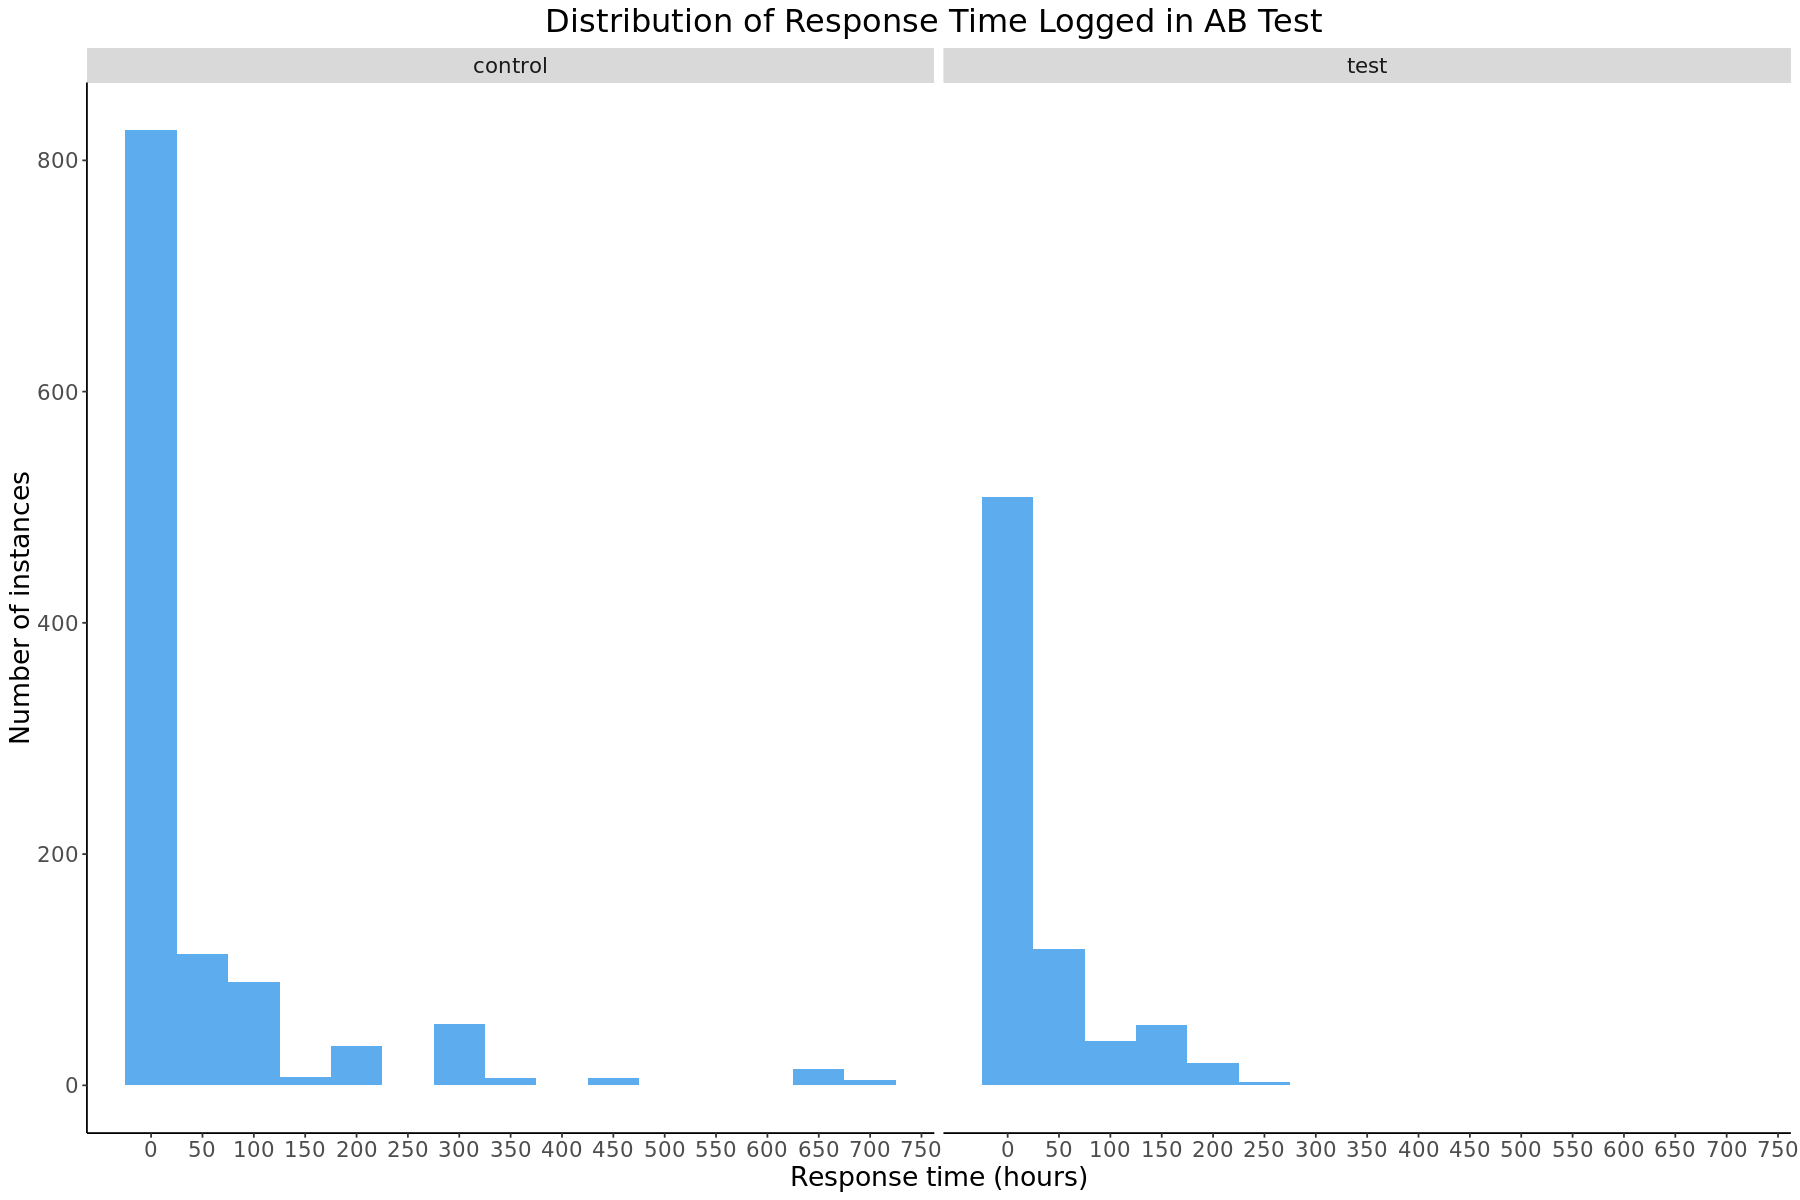

In [406]:
# Create histogram

response_histogram <- topic_response_data_exp %>%
    mutate(response_time = difftime(response_dt, comment_dt, units = "secs")) %>%  
    #filter(response_time < 3600)  %>%  #remove significant outliers to help more clearly see distribution of majority
    ggplot(aes(x=response_time/3600)) +  #round to nearest hour
    geom_histogram(binwidth = 50, fill = 'steelblue2') +
    facet_wrap(~ experiment_group) +
    scale_x_continuous(labels = scales::comma, breaks=seq(0,800,50)) +
    labs (title = "Distribution of Response Time Logged in AB Test ",
          y = "Number of instances",
         x= "Response time (hours)")   + 
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

response_histogram

There are fewer outliers (long response times) in the control group.

## Overall across both test groups

In [408]:
# find the average time difference

avg_time_response_overall <- topic_response_data_exp %>%
    mutate(response_time = difftime(response_dt, comment_dt, units = "secs")) %>%  ## add column to show response time
    group_by(experiment_group) %>%
    summarise(median_response_time = as.integer(median(response_time/ 60)),
             mean_response_time = as.integer(mean(response_time/60)),
             ) 
   

avg_time_response_overall

`summarise()` ungrouping output (override with `.groups` argument)



experiment_group,median_response_time,mean_response_time
<fct>,<int>,<int>
control,90,2919
test,39,1860


#### Quick look at percentiles

In [424]:
avg_time_response_percentiles <- topic_response_data_exp %>%
    mutate(response_time = difftime(response_dt, comment_dt, units = "mins")) %>%  ## add column to show response time
    group_by(experiment_group) %>%
    summarise(quantile = scales::percent(c(0.25, 0.5, 0.75)),
            response_time = round(quantile(response_time, c(0.25, 0.5, 0.75)), 0) )%>%
    pivot_wider(names_from = quantile, values_from = response_time)
    

avg_time_response_percentiles

`summarise()` regrouping output by 'experiment_group' (override with `.groups` argument)



experiment_group,25%,50%,75%
<fct>,<drtn>,<drtn>,<drtn>
control,6 mins,90 mins,2713 mins
test,2 mins,39 mins,2620 mins


The average is heavily influenced by the 90th percentile, the tail, rather than the majority of the response times.

Ho75% of response times are complete in under 3000 minutes. The 50% percentile indicated that half of the response times were below and half were above this value.

We should use the median (50th) percentile as a better indicator of the typical response time in the test.

In [425]:
# join the two data sets
# find percent reponse rate
response_time_stats <- inner_join(avg_time_response_overall, avg_time_response_percentiles, by = c("experiment_group")) 
response_time_stats 


experiment_group,median_response_time,mean_response_time,25%,50%,75%
<fct>,<int>,<int>,<drtn>,<drtn>,<drtn>
control,90,2919,6 mins,90 mins,2713 mins
test,39,1860,2 mins,39 mins,2620 mins


In [452]:
# Create table of completion rate
avg_time_response_overall_table <- avg_time_response_overall%>%
  gt() %>%
  tab_header(
    title = "Summary of response times across all participating Wikipedias",
  )  %>%
  cols_label(
    experiment_group = "Experiment Group",
    median_response_time = "Median response time (minutes)",
    mean_response_time = "Mean response time (minutes)"
  ) %>%
  tab_footnote(
    footnote = "Defined as the midpoint of identified time durations from Person A posting on a talk page and Person B posting a response",
    locations = cells_column_labels(
      columns = "median_response_time"
    )
  ) %>%
  tab_footnote(
    footnote = 'Test: Topic subscriptions enabled by default; Control: Topic subscriptions not enabled',
    locations = cells_column_labels(
      columns = 'experiment_group')
    ) %>%
   tab_footnote(
    footnote = 'Defined as the average time duration from Person A posting on a talk page and Person B posting a response"',
    locations = cells_column_labels(
      columns = 'mean_response_time')
    ) %>%
    gtsave(
    "avg_time_response_overall_table.html", inline_css = TRUE)

IRdisplay::display_html(data = avg_time_response_overall_table , file = "avg_time_response_overall_table.html")

"1 Test: Topic subscriptions enabled by default; Control: Topic subscriptions not enabled 2 Defined as the midpoint of identified time durations from Person A posting on a talk page and Person B posting a response 3 Defined as the average time duration from Person A posting on a talk page and Person B posting a response"""


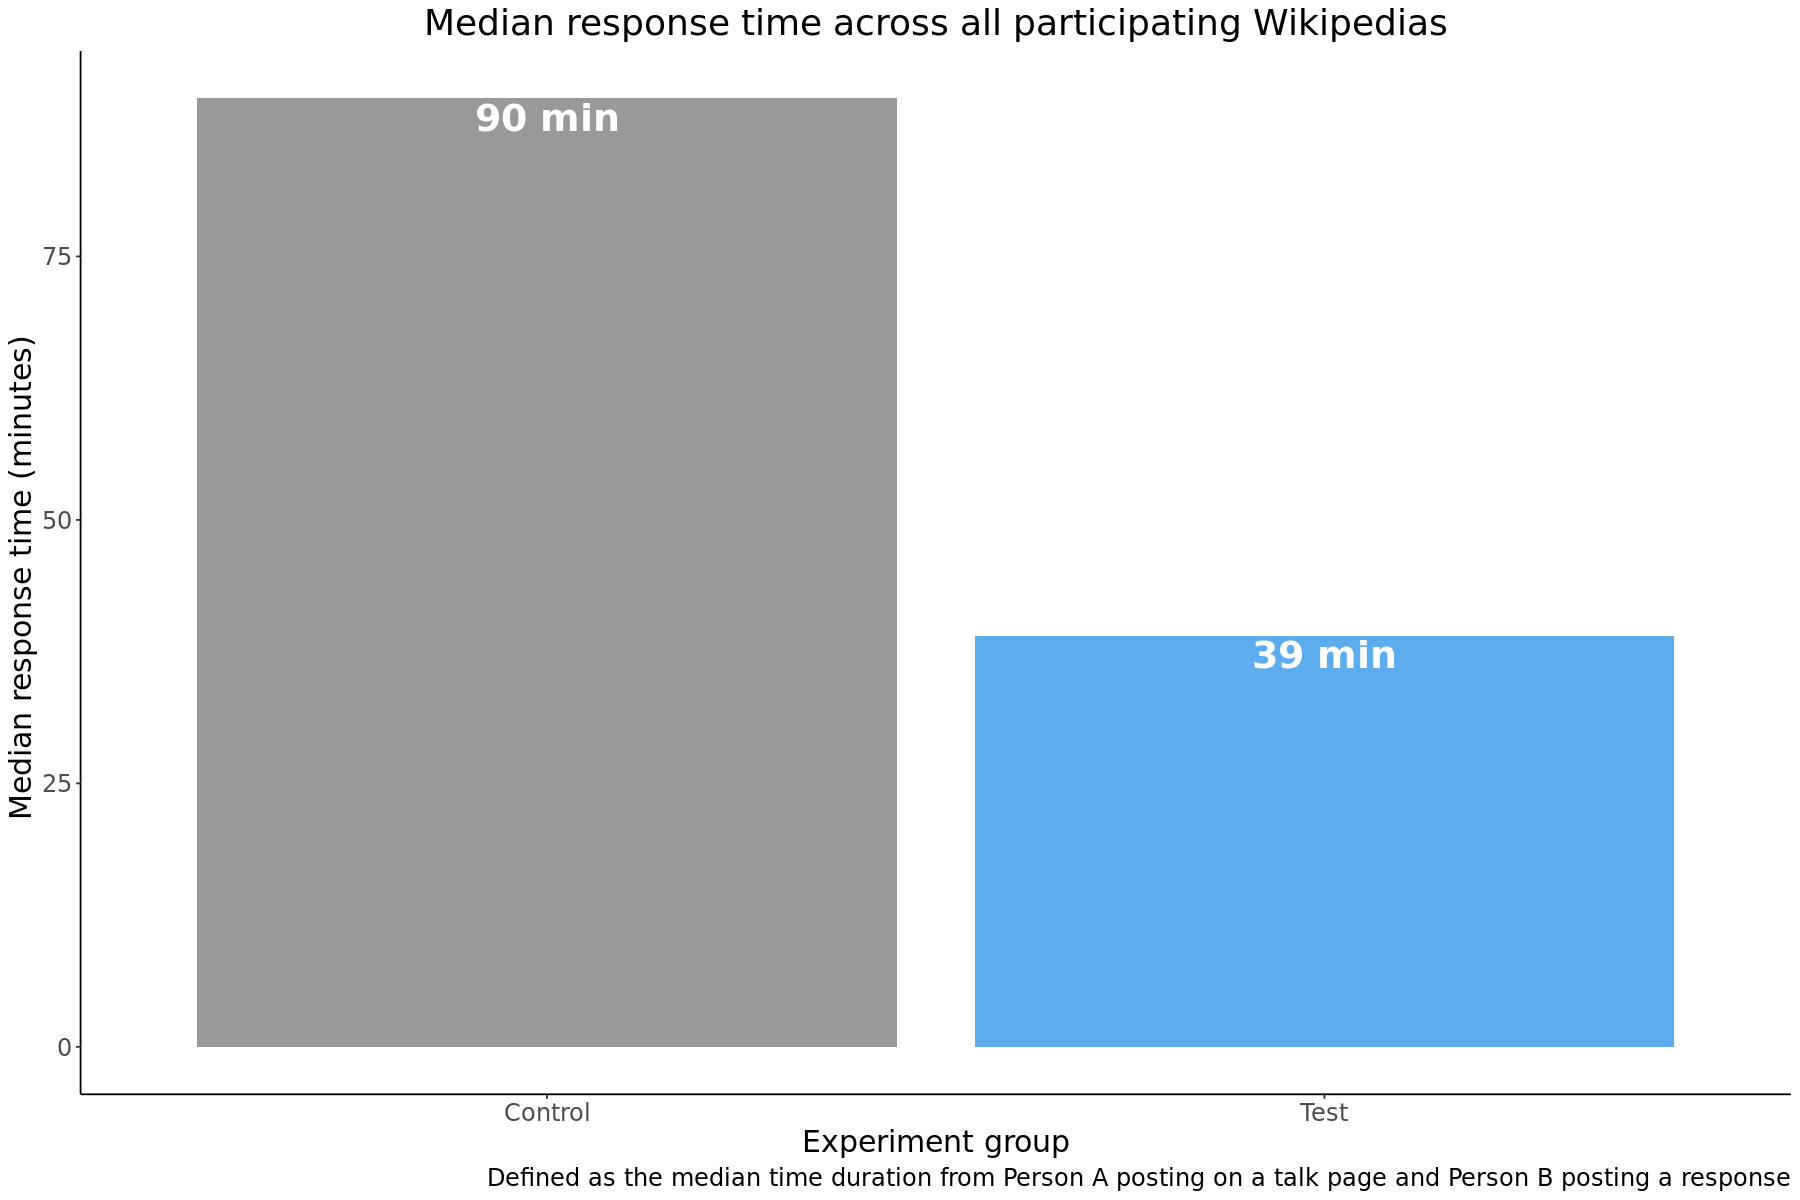

In [458]:
p <- avg_time_response_overall  %>%
    ggplot(aes(x= experiment_group, y = median_response_time, fill = experiment_group)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(median_response_time, "min"), fontface=2), vjust=1.2, size = 8, color = "white") +
    scale_y_continuous() +
    scale_x_discrete(labels = c("Control", "Test")) +
    labs (y = "Median response time (minutes) ",
          x = "Experiment group",
          title = "Median response time across all participating Wikipedias",
         caption = "Defined as the median time duration from Person A posting on a talk page and Person B posting a response")  +
    scale_fill_manual(values= c("#999999", "steelblue2")) +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        legend.position= "none",
        axis.line = element_line(colour = "black")) 
 

p
ggsave("Figures/median_time_response_overall.png", p, width = 16, height = 8, units = "in", dpi = 300)

### By experience level

In [447]:
# find the average time difference

avg_time_response_byexp <- topic_response_data_exp %>%
    mutate(response_time = difftime(response_dt, comment_dt, units = "mins")) %>%  ## add column to show response time
    group_by(experiment_group, experience_group) %>%
     summarise(median_response_time_minutes = as.integer(median(response_time)),
             mean_response_time_minutes = as.integer(mean(response_time))) %>%
    arrange(experience_group)

avg_time_response_byexp

`summarise()` regrouping output by 'experiment_group' (override with `.groups` argument)



experiment_group,experience_group,median_response_time_minutes,mean_response_time_minutes
<fct>,<fct>,<int>,<int>
control,0-100 edits,62,249
test,0-100 edits,3,893
control,101-500 edits,34,7532
test,101-500 edits,55,1421
control,over 500 edits,90,2240
test,over 500 edits,311,2391


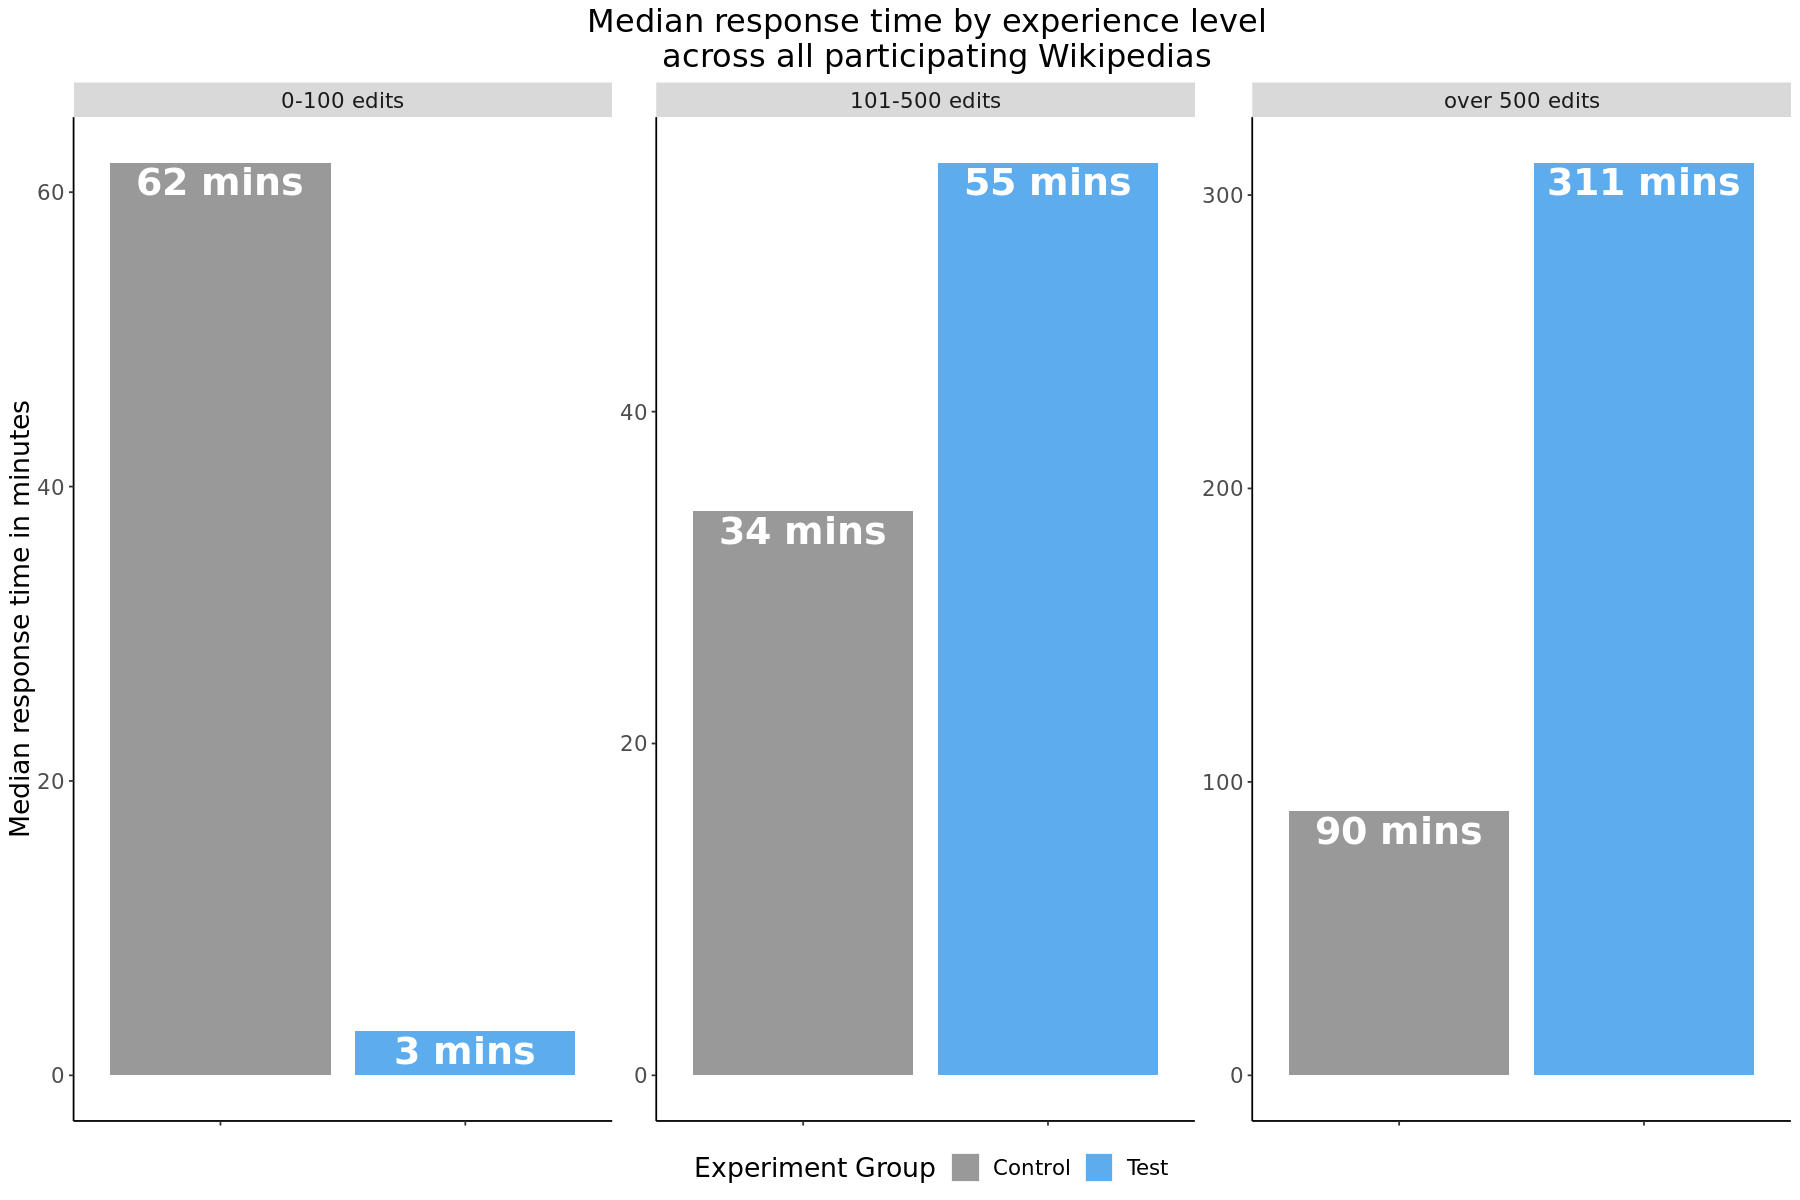

In [449]:
# Plot edit completion rates for each user on each wiki  

p <- avg_time_response_byexp %>%
    ggplot(aes(x= experiment_group, y = median_response_time_minutes, fill = experiment_group)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(median_response_time_minutes, "mins"), fontface=2), vjust=1.2, size = 8, color = "white") +
    facet_wrap(~ experience_group, scales = "free_y") +
    scale_y_continuous() +
    labs (y = "Median response time in minutes",
          title = "Median response time by experience level \n across all participating Wikipedias"
          )+
      scale_fill_manual(values= c("#999999", "steelblue2"), name = "Experiment Group", labels = c("Control", "Test"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

p 
ggsave("Figures/avg_time_response_byexp.png", p, width = 16, height = 8, units = "in", dpi = 300)

# By Wiki

ERROR: Error: Unknown graphics device ''


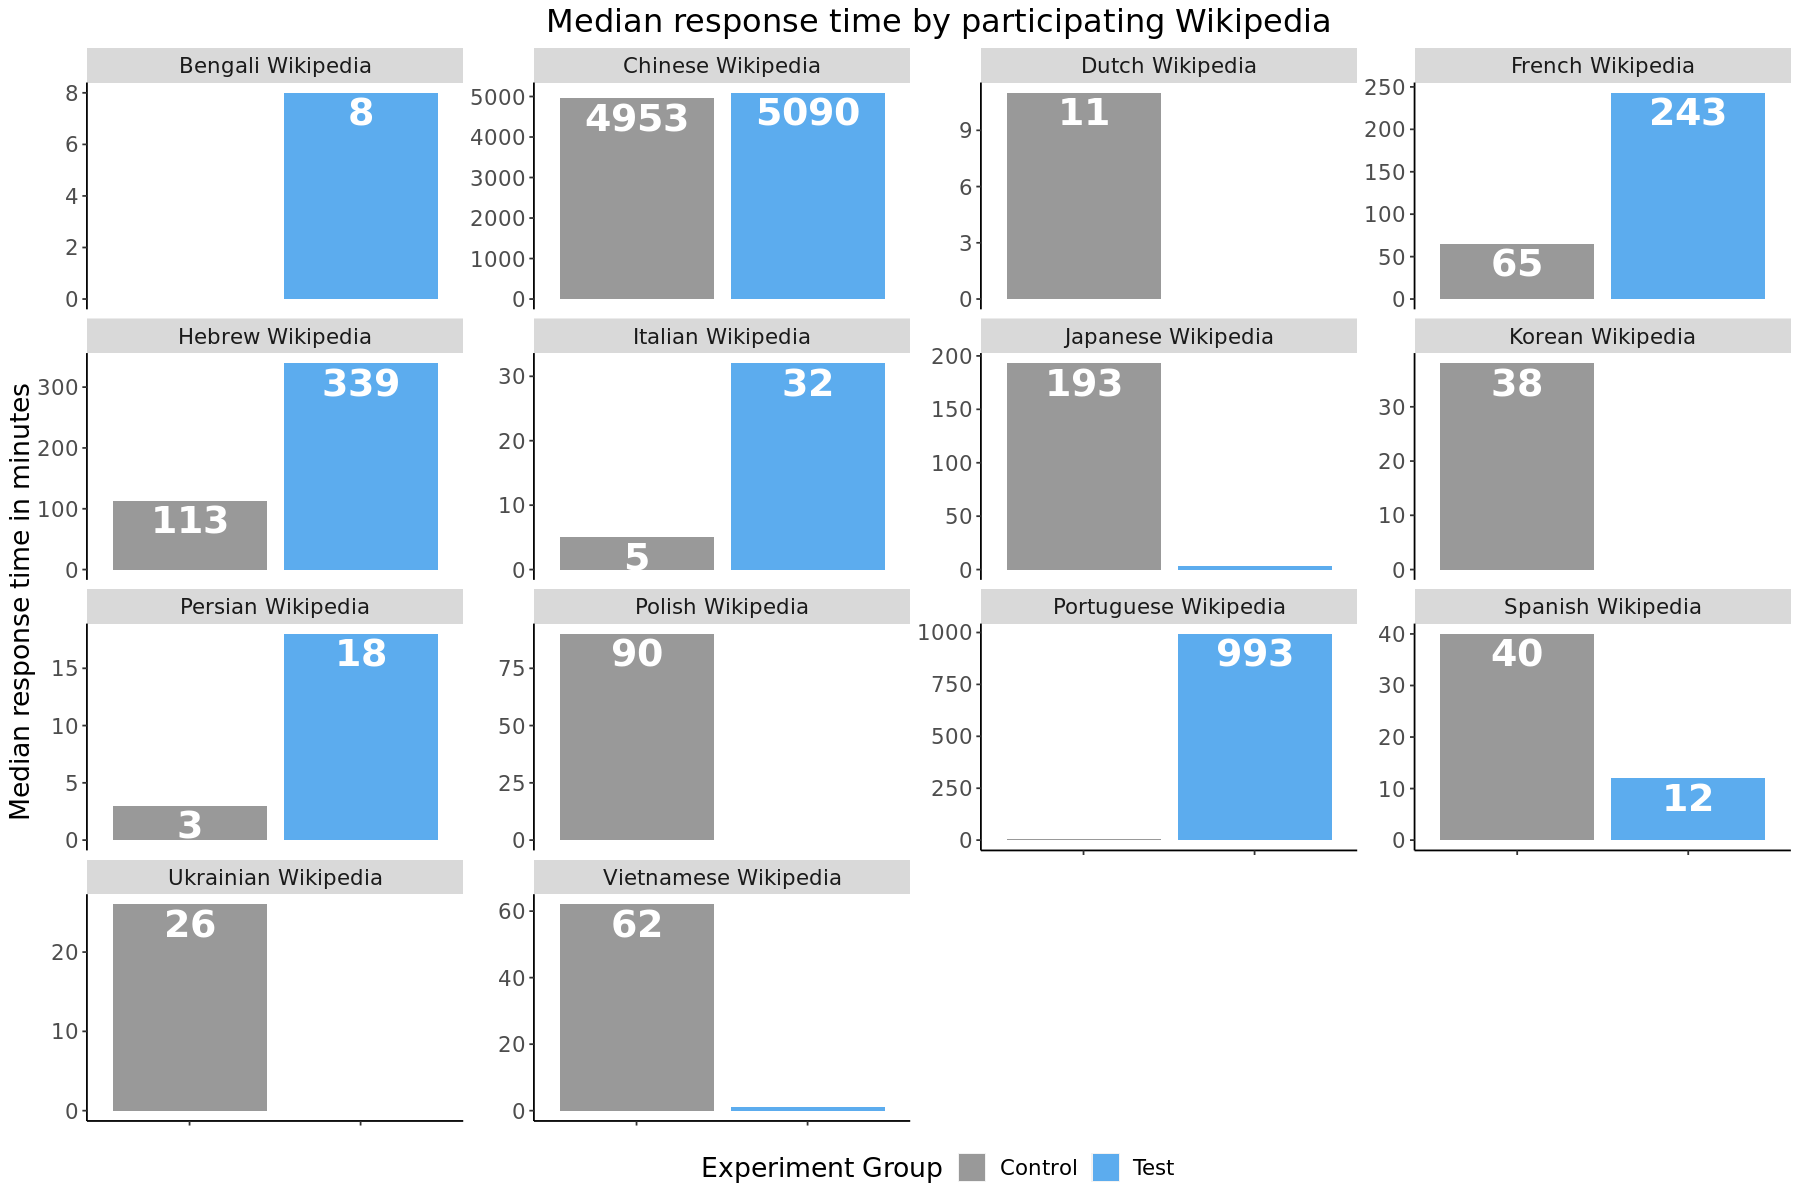

In [402]:
# Plot edit completion rates for each user on each wiki  

p <- avg_time_response_bywiki %>%
    ggplot(aes(x= experiment_group, y = median_response_time_minutes, fill = experiment_group)) +
    geom_col(position = 'dodge') +
    geom_text(aes(label = paste(median_response_time_minutes), fontface=2), vjust=1.2, size = 8, color = "white") +
    facet_wrap(~ wiki, scales = "free_y") +
    scale_y_continuous() +
    labs (y = "Median response time in minutes",
          title = "Median response time by participating Wikipedia"
          )+
      scale_fill_manual(values= c("#999999", "steelblue2"), name = "Experiment Group", labels = c("Control", "Test"))  +
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=16),
        legend.position="bottom",
        axis.text.x = element_blank(),
        axis.title.x=element_blank(),
        axis.line = element_line(colour = "black")) 

p 
ggsave("Figures/avg_time_response_bywiki", p, width = 16, height = 8, units = "in", dpi = 300)

# Curiosity #1: Average and total number of comments or new topics posted on talk pages by contributors that edit a talk page, grouped by experience level

## Total number of comments posted by users within each experiment group
### Overall

In [376]:
talk_page_comments_bygroup <- topic_events %>%
  filter(edit_save_status == 'comment_posted')  %>%
  group_by(experiment_group) %>%
  summarise(n_users = n_distinct(user_id),
        n_comments = n_distinct(edit_attempt_id))

talk_page_comments_bygroup

`summarise()` ungrouping output (override with `.groups` argument)



experiment_group,n_users,n_comments
<chr>,<int>,<int>
control,4990,27258
test,5021,26880


There is a not a signficant diffrence in the number of users or comments posted on talk pages within each group. 

In [323]:
talk_page_comments_bytype <- topic_events %>%
  filter(edit_save_status == 'comment_posted')  %>%
  group_by(experiment_group, comment_type) %>%
  summarise(n_users = n_distinct(user_id),
        n_comments = n_distinct(edit_attempt_id))

talk_page_comments_bytype

`summarise()` regrouping output by 'experiment_group' (override with `.groups` argument)



experiment_group,comment_type,n_users,n_comments
<chr>,<chr>,<int>,<int>
control,comment,357,663
control,response,3010,14775
control,topic,3295,11968
test,comment,362,706
test,response,3081,14288
test,topic,3296,12051


## Comments with a response

In [377]:
# Find all all topics or new comments that have received a response. 
# Topics with response - commment parent id = topic_id
# Comments with a response - comment_id = comment_parent id

comments_w_response <- topic_events %>%
    filter(comment_type != 'topic') %>%  #all topics by definition have a comment added to them
    filter(edit_save_status == 'comment_posted',
          comment_id %in% comment_parent_id |
          topic_id %in% comment_parent_id  ) %>% # comments and topics that recieved a response
 group_by(experiment_group) %>%
  summarise(n_users_wresponse = n_distinct(user_id),
        n_comments_wresponse = n_distinct(edit_attempt_id))


`summarise()` ungrouping output (override with `.groups` argument)



In [378]:
head(comments_w_response)

experiment_group,n_users_wresponse,n_comments_wresponse
<chr>,<int>,<int>
control,1249,5022
test,1235,4772


In [380]:
# find percent reponse rate
response_pct <- inner_join(talk_page_comments_bygroup, comments_w_response, by = c("experiment_group")) %>%
    group_by(experiment_group) %>%
    mutate(pct_users_w_reponse = paste0(round(n_users_wresponse/n_users * 100, 2), "%"),
           pct_comments_w_reponse = paste0(round(n_comments_wresponse/n_comments * 100, 2), "%"))
response_pct

experiment_group,n_users,n_comments,n_users_wresponse,n_comments_wresponse,pct_users_w_reponse,pct_comments_w_reponse
<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>
control,4990,27258,1249,5022,25.03%,18.42%
test,5021,26880,1235,4772,24.6%,17.75%


## Average daily number of comments or new topics across all contributors

In [470]:
avg_daily_comments <- topic_events %>%
    filter(edit_save_status == 'comment_posted') %>%
 group_by(save_dt, experiment_group) %>%
  summarise(n_comments_total = n_distinct(comment_id)) %>%
 group_by(experiment_group) %>%
summarise(n_comments_total = mean(n_comments_total))

avg_daily_comments

`summarise()` regrouping output by 'save_dt' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



experiment_group,n_comments_total
<chr>,<dbl>
control,668.3864
test,655.0000


In [468]:
## Average number of comments or new topics by each distinct contributor grouped by experience level

avg_daily_comments_bycontributor <- topic_events %>%
    filter(edit_save_status == 'comment_posted') %>%
 group_by(user_id,  experiment_group, experience_group)  %>%
  summarise(n_comments_total = n_distinct(comment_id))  %>%
 group_by(experiment_group, experience_group) %>%
summarise(avg_comments = round(mean(n_comments_total), 2))

avg_daily_comments_bycontributor

`summarise()` regrouping output by 'user_id', 'experiment_group' (override with `.groups` argument)

`summarise()` regrouping output by 'experiment_group' (override with `.groups` argument)



experiment_group,experience_group,avg_comments
<chr>,<fct>,<dbl>
control,0-100 edits,2.04
control,101-500 edits,3.80
control,over 500 edits,10.53
test,0-100 edits,2.12
test,101-500 edits,3.78
test,over 500 edits,10.12


# Guardrail #3: Percent change in the number of Senior Contributors making edits to talk page [COMPLETE]

Topic Subscriptions should not cause a significant (read: sharp) increase or decrease in the number of Senior Contributors editing talk pages.

For this analysis, we conducted a pre and post deployment analysis to determine any signficant changes in the number of contributors that started an edit to a talk page on the wikis where the AB test was deployed. Since we are including events logged prior to the AB test, we did not limit data to just the AB test but all edit attempts logged before and after deployment.

In [336]:
query <-
"SELECT
date_format(dt, 'yyyy-MM-dd') as attempt_dt,
event.user_id,
wiki,
COUNT(*) as n_edits
FROM
event.editattemptstep
WHERE
Year = 2022
AND month >= 05  --look at some time prior and post deployment of the AB test
AND event.action = 'init'
AND useragent.is_bot = false
-- review all talk namespaces
  AND event.page_ns % 2 = 1
   AND event.platform = 'desktop'
   AND event.action = 'init'
-- review participating wikis list
  AND wiki IN ('amwiki', 'arzwiki', 'bnwiki', 'eswiki', 'fawiki', 'frwiki', 'hewiki',  'hiwiki',  'idwiki', 'itwiki',  'jawiki',  
 'kowiki', 'nlwiki', 'omwiki', 'plwiki', 'ptwiki',  'thwiki',
    'ukwiki', 'viwiki','zhwiki')
-- only logged in users
  AND event.user_id != 0 
  AND event.user_editcount > 500 -- only senior editrs
GROUP BY
date_format(dt, 'yyyy-MM-dd'),
event.user_id,
wiki
"

In [337]:
senior_contributor_edits <- wmfdata::query_hive(query)

Don't forget to authenticate with Kerberos using kinit



In [338]:
# convert time sent to date time
senior_contributor_edits$attempt_dt <- as.Date(senior_contributor_edits$attempt_dt, format = "%Y-%m-%d")

In [339]:
senior_contributor_daily_edits  <- senior_contributor_edits %>%
    group_by(attempt_dt) %>%
    summarise(n_users = n_distinct(user_id))

`summarise()` ungrouping output (override with `.groups` argument)



ERROR: Error: Unknown graphics device ''


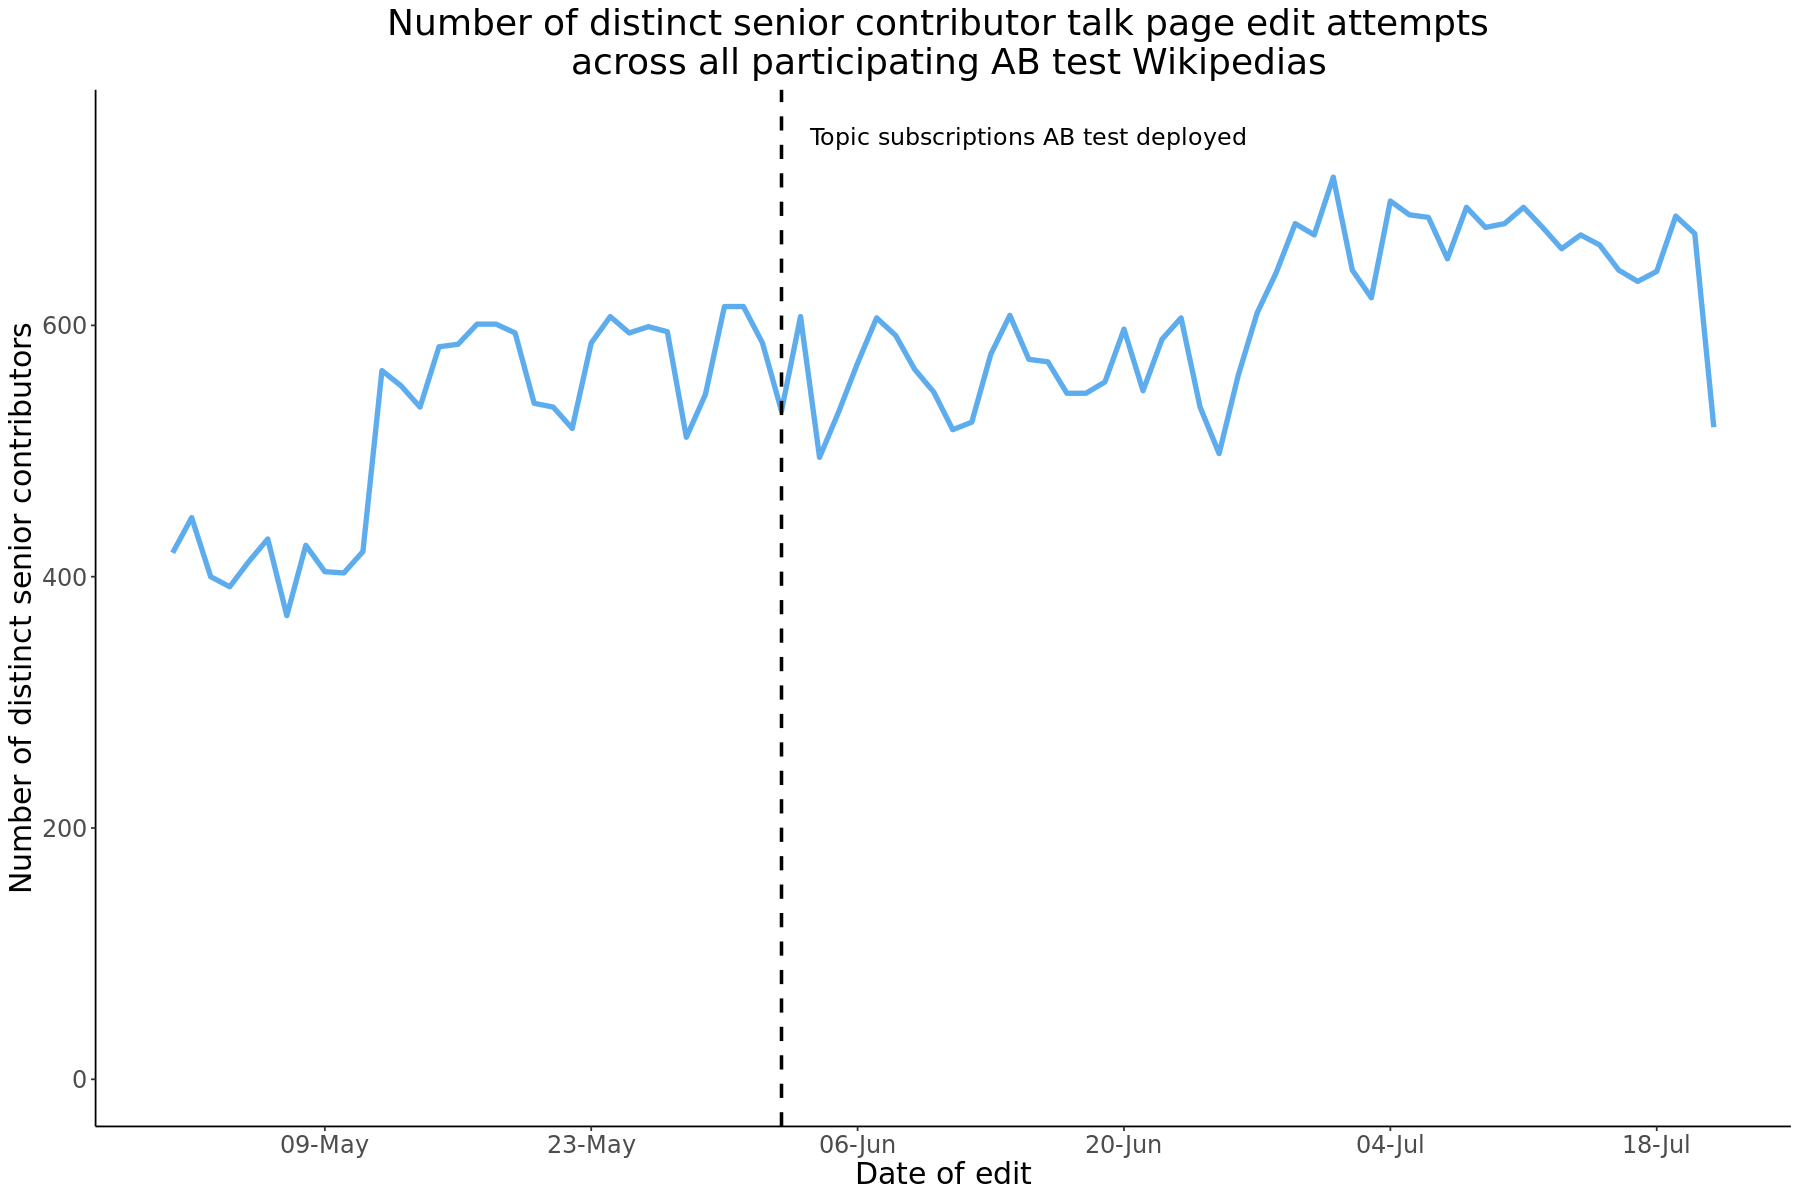

In [476]:
# Plot edit completion rates for each user on each wiki  


textaes <- data.frame(y = 750,
                      x = as.Date('2022-06-15'),
                      lab = "Topic subscriptions AB test deployed")

p <- senior_contributor_daily_edits %>%
    ggplot(aes(x= attempt_dt, y = n_users)) +
    geom_line(size = 1.5,color = "steelblue2") +
    geom_vline(xintercept = as.Date('2022-06-02'), linetype = 'dashed', size = 1) +
    scale_x_date(date_labels = "%d-%b", date_breaks = "2 weeks", minor_breaks = NULL) +
    scale_y_continuous(limit = c(0, 750)) +
    geom_text(mapping = aes(y = y, x = x, label = lab), 
            data = textaes, inherit.aes = FALSE, size = 5) +
    labs (y = "Number of distinct senior contributors",
          x = "Date of edit",
          title = "Number of distinct senior contributor talk page edit attempts \n across all participating AB test Wikipedias"
          )+
    theme(
        panel.grid.minor = element_blank(),
        panel.background = element_blank(),
        plot.title = element_text(hjust = 0.5),
        text = element_text(size=18),
        legend.position="bottom",
        axis.line = element_line(colour = "black")) 

p 
ggsave("Figures/senior_contributor_daily_edits", p, width = 16, height = 8, units = "in", dpi = 300)

### Percent change calculation

In [365]:
senior_contributor_pct_change  <- senior_contributor_edits %>%
    filter(attempt_dt >= "2022-05-19" & attempt_dt <= "2022-06-16") %>% #two weeks before and after
    mutate(pre_post = ifelse(attempt_dt < '2022-06-02', 'pre', 'post')) %>%
    group_by(pre_post) %>%
    summarise(n_users = n_distinct(user_id))

senior_contributor_pct_change

`summarise()` ungrouping output (override with `.groups` argument)



pre_post,n_users
<chr>,<int>
post,3035
pre,3054


Before and after the AB test deployment, we only see less than a 1% change in the number of distinct senior contributors.

## By Wiki

In [366]:
senior_contributor_daily_edits_wiki  <- senior_contributor_edits %>%
    group_by(wiki, attempt_dt) %>%
    summarise(n_users = n_distinct(user_id))

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



In [375]:
senior_contributor_pct_change_wiki  <- senior_contributor_edits %>%
    filter(attempt_dt >= "2022-05-19" & attempt_dt <= "2022-06-16") %>% #two weeks before and after
    mutate(pre_post = ifelse(attempt_dt < '2022-06-02', 'pre', 'post')) %>%
    group_by( wiki, pre_post) %>%
    summarise(n_users = n_distinct(user_id)) %>%
    pivot_wider(names_from = pre_post, values_from = n_users)%>%
    arrange(wiki)

senior_contributor_pct_change_wiki

`summarise()` regrouping output by 'wiki' (override with `.groups` argument)



wiki,post,pre
<chr>,<int>,<int>
arzwiki,2,3
bnwiki,32,35
eswiki,337,332
fawiki,91,103
frwiki,624,621
hewiki,226,224
hiwiki,7,6
idwiki,54,38
itwiki,386,374


There were no signficant changes in the number of senior contributors on a per wiki basis.

# Curiosity 2: Percent of contributors that edit a talk page and start a new topic or comment, grouped by the number of topics (e.g. 1-5, 6-10, 11-15, etc) they've started and experience level

PENDING